In [96]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as datasets
import time

import matplotlib.pyplot as plt

# Download MNIST data

In [6]:
train_dataset = datasets.MNIST(root='./data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

In [9]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [18]:
type(train_dataset[0])

tuple

In [14]:
train_dataset[0][0][0].shape

torch.Size([28, 28])

Label 7


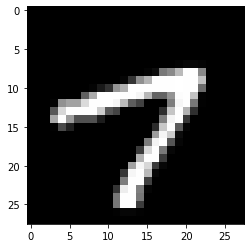

In [34]:
img_num = 101

img_example = train_dataset[img_num][0].numpy().reshape(28,28)
img_example.shape
plt.imshow(img_example, cmap='gray')
print('Label {}'.format(train_dataset[img_num][1]))

# Make datasets iterable

In [35]:
len(train_dataset)

60000

In [36]:
batch_size = 100
epochs = 5
iterations = epochs * len(train_dataset)/batch_size
print('Iterations {}'.format(iterations))

Iterations 3000.0


In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [39]:
#check for dataset iterability
import collections
isinstance(train_loader, collections.Iterable)

True

In [40]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [41]:
#check for dataset iterability
import collections
isinstance(test_loader, collections.Iterable)

True

# Build model

In [42]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.Linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        out = self.Linear(x)
        return out

In [43]:
input_dim = 28*28
output_dim = 10
model = LogisticRegression(input_dim, output_dim)

In [102]:
model

LogisticRegression(
  (Linear): Linear(in_features=784, out_features=10, bias=True)
)

In [44]:
criterion = nn.CrossEntropyLoss()

In [46]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [49]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0107, -0.0262, -0.0162,  ..., -0.0071, -0.0035,  0.0063],
         [-0.0158,  0.0321,  0.0351,  ..., -0.0011, -0.0285, -0.0332],
         [-0.0106,  0.0056, -0.0063,  ..., -0.0171,  0.0299, -0.0098],
         ...,
         [ 0.0351,  0.0276,  0.0343,  ..., -0.0188, -0.0357, -0.0324],
         [-0.0263,  0.0353,  0.0135,  ..., -0.0339,  0.0210, -0.0203],
         [-0.0026,  0.0193, -0.0252,  ...,  0.0284, -0.0030, -0.0139]],
        requires_grad=True), Parameter containing:
 tensor([-0.0250,  0.0305, -0.0147, -0.0256,  0.0273,  0.0008,  0.0079, -0.0185,
         -0.0127, -0.0213], requires_grad=True)]

In [60]:
print('Coefficents : {}'.format(list(model.parameters())[0].shape))
print('Bias : {}'.format(list(model.parameters())[1].shape))

Coefficents : torch.Size([10, 784])
Bias : torch.Size([10])


# Train model

In [99]:
#CPU implementation
input_dim = 28*28
output_dim = 10
model = LogisticRegression(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

accuracy = -999
itern = 0
start_time = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images.view(-1,28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss_val = loss.data.numpy().reshape(1)[0]
        loss.backward()
        
        optimizer.step()
        
        itern += 1
        if itern%500 ==0:
            correct = 0
            total = 0
            for test_images, test_labels in test_loader:
                test_images = Variable(test_images.view(-1, 28*28))
                test_preds = model(test_images)
                _, predicted = torch.max(test_preds.data, 1)
                total +=  test_labels.size(0)
                correct += (predicted == test_labels).sum()
            correct = correct.numpy().reshape(1)[0]
            accuracy = 100 * correct/total    
            print('Epoch {}, Iter {}, Loss {}, Accuracy {}'.format(epoch, itern,loss_val, accuracy))
print('Training time {}'.format(time.time() - start_time))

Epoch 0, Iter 500, Loss 0.8704499006271362, Accuracy 84.85
Epoch 1, Iter 1000, Loss 0.6596279740333557, Accuracy 87.09
Epoch 2, Iter 1500, Loss 0.5788799524307251, Accuracy 87.85
Epoch 3, Iter 2000, Loss 0.45839253067970276, Accuracy 88.47
Epoch 4, Iter 2500, Loss 0.35587742924690247, Accuracy 88.95
Epoch 4, Iter 3000, Loss 0.5180630087852478, Accuracy 89.22
Training time 73.30112791061401


In [104]:
#GPU implementation
input_dim = 28*28
output_dim = 10
model = LogisticRegression(input_dim, output_dim)
model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

accuracy = -999
itern = 0
start_time = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images.view(-1,28*28).cuda())
        labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss_val = loss.data.cpu().numpy().reshape(1)[0]
        loss.backward()
        
        optimizer.step()
        
        itern += 1
        if itern%500 ==0:
            correct = 0
            total = 0
            for test_images, test_labels in test_loader:
                test_images = Variable(test_images.view(-1, 28*28).cuda())
                test_preds = model(test_images)
                _, predicted = torch.max(test_preds.data, 1)  
                predicted = predicted.cpu()
                total +=  test_labels.size(0)
                correct += (predicted == test_labels).sum()
            correct = correct.numpy().reshape(1)[0]
            accuracy = 100 * correct/total    
            print('Epoch {}, Iter {}, Loss {}, Accuracy {}'.format(epoch, itern,loss_val, accuracy))
print('Training time {}'.format(time.time() - start_time))

Epoch 0, Iter 500, Loss 0.8775678277015686, Accuracy 84.78
Epoch 1, Iter 1000, Loss 0.7548774480819702, Accuracy 86.96
Epoch 2, Iter 1500, Loss 0.4737601578235626, Accuracy 88.03
Epoch 3, Iter 2000, Loss 0.4712175130844116, Accuracy 88.56
Epoch 4, Iter 2500, Loss 0.4331512749195099, Accuracy 89.04
Epoch 4, Iter 3000, Loss 0.40139007568359375, Accuracy 89.28
Training time 41.84153485298157
